In [ ]:
#Importacion de datos desde Kaggle
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-faces:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F667852%2F1176357%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240626%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240626T023538Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9944c0bce6989a6684ece8d56485579cdbfa9ee79c8c1ddb2a512c777cadf47f0ee967aaad096a6fe6f7104b40f425df30526849c1697118bf3789c639dc5d9fd8d41d04165bc207f0579dc686b3107799957425e361b3dc6e0addd4eaa746502c5968802d6eaed8649dea7477755ccfd04d4735d1214f298c3e3acc3a94eb0946f55d1b4a29098578b140fd73758dc63a77d4fa56e86c88f99cf3b6bb33da901195634361a60d061bb429c1b48e14bc187528c0f809f4101265e3c06bb73404f45e9dab9b4089031e49474b2863817a7fbb674bd21c84c74e74cf9f85731b3b4b5fc239eccf296e4f0cccd6c26ff1c96a9581047cae16b0112bedea0d634b5b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 729700755 bytes downloaded
Downloaded and uncompressed: animal-faces
Data source import complete.


# Modelo StyleGan pytorch


Adaptación de implementación de StyleGAN a esquema de una sola clase, visualización de datos y evaluación de performance basado en la Frechet Inception Distance.

Notebook original:
https://www.kaggle.com/code/tauilabdelilah/stylegan-implementation-from-scratch-pytorch/notebook

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt
import glob
from keras.preprocessing import image
import gc

#Carga y exploración de datos

In [ ]:
DATSET = '/kaggle/input/animal-faces/afhq/train'
START_TRAIN_IMG_SIZE = 4
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [256,256,128,128,128,128]
CHANNELS_IMG = 3

In [ ]:
def get_loader(image_size):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ])
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    num_workers = os.cpu_count()  # Utilizar todos los núcleos de CPU disponibles
    dataset = datasets.ImageFolder(root=DATSET, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return loader, dataset


In [ ]:

def get_loader_(image_size, data_path):

    subcarpetas = [f.path for f in os.scandir(data_path) if f.is_dir()]
    print('Subcarpetas encontradas:', subcarpetas)

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ])
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    num_workers = os.cpu_count()
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return loader, dataset



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


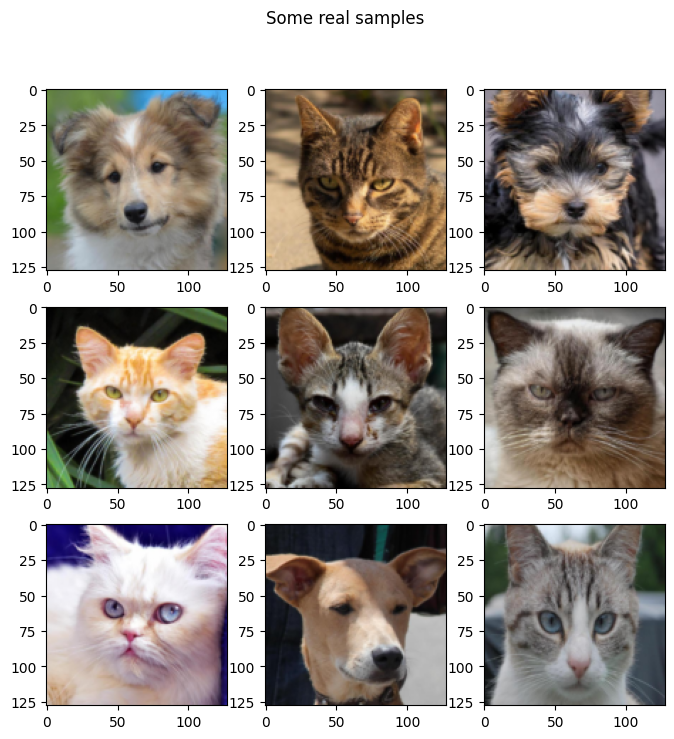

In [ ]:
def check_loader():
    loader,_ = get_loader(128)
    cloth,_  = next(iter(loader))
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1
check_loader()

In [ ]:
import tensorflow as tf
from keras.applications.densenet import DenseNet201, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = DenseNet201(weights='imagenet', include_top=False)

#Número de clases
k=3

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(k, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

74836368/74836368 [==============================] - 3s 0us/step


In [ ]:


filenames = np.array(glob.glob('/kaggle/input/animal-faces/afhq/train/cat/*.jpg'))

target_size=(128,128)

features_convnet = []
features_pixels = []

for filename in tqdm(filenames):
  img = image.load_img(filename, target_size=target_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features_convnet.append(model.predict(x, verbose=0).ravel())
  features_pixels.append(x.ravel())
features_convnet = np.array(features_convnet)
features_pixels = np.array(features_pixels)
features_convnet.shape, features_pixels.shape

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
K = 5 #Puede cambiarlo
init = 'k-means++' #Puede cambiarlo por 'k-means++'
n_init = 1 #Puede cambiarlo

Mostrando imágenes del cluster 0

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_003153.jpg


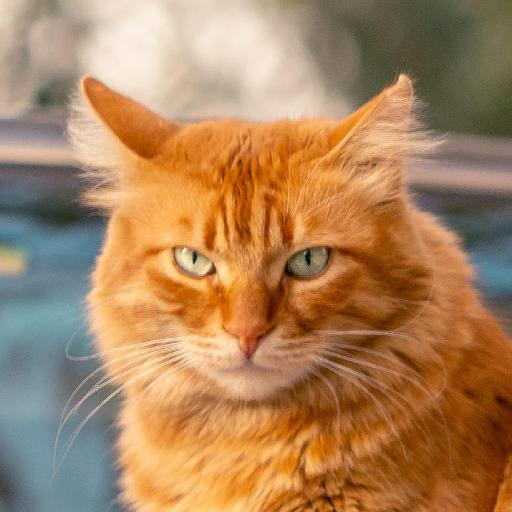

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002999.jpg


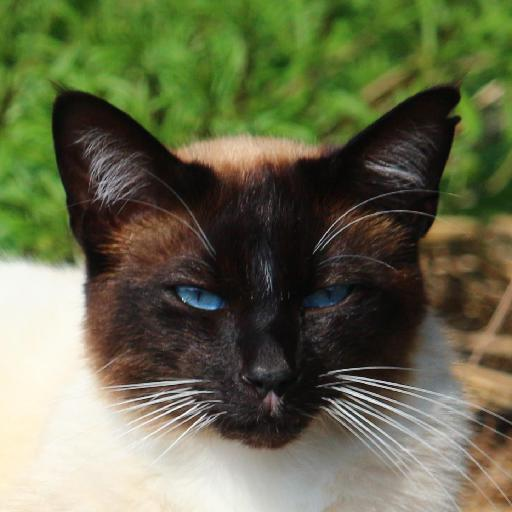

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_003593.jpg


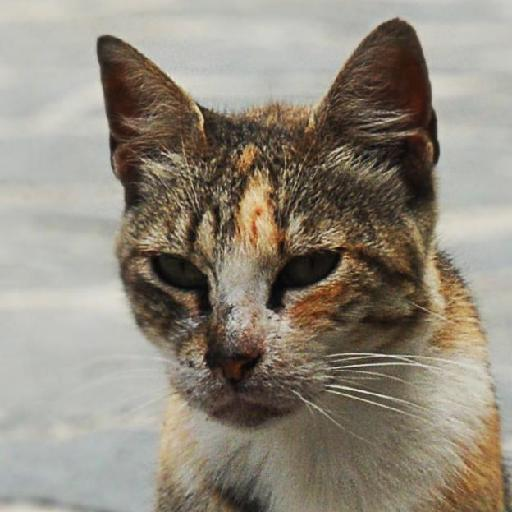

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002523.jpg


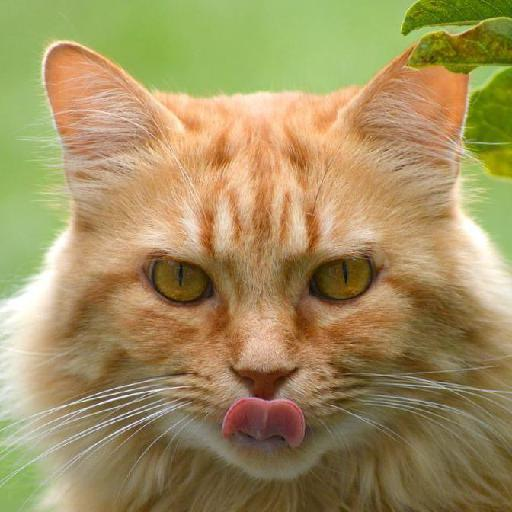

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004740.jpg


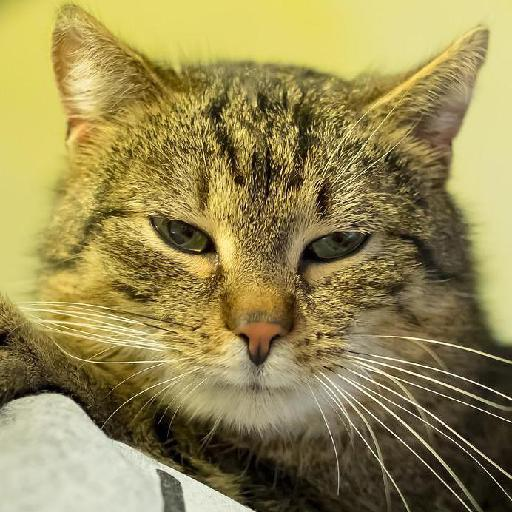

In [ ]:
from IPython.display import Image
cluster_id = 0 #número del cluster a visualizar
max_images = 5 #máxima cantidad de imágenes a visualizar

print("Mostrando imágenes del cluster {}\n".format(cluster_id))

imagenes_en_cluster = filenames[asignacion_clusters==cluster_id]

if len(imagenes_en_cluster)<= max_images:
  imagenes_a_mostrar = imagenes_en_cluster
else:
  imagenes_a_mostrar = np.random.choice(imagenes_en_cluster, max_images, replace=False)

i = 0
for filename in imagenes_a_mostrar:
  print(filename)
  display(Image(filename))
  i += 1
  if i > max_images:
    break

In [ ]:
K = 20 #Puede cambiarlo
init = 'k-means++' #Puede cambiarlo por 'k-means++'
n_init = 1 #Puede cambiarlo

In [ ]:
kmeans = KMeans(n_clusters = K, verbose=2, init=init, n_init=n_init)
kmeans.fit(features_convnet)
asignacion_clusters = kmeans.predict(features_convnet)

Initialization complete
Iteration 0, inertia 28.83708953857422.
Iteration 1, inertia 24.151477813720703.
Iteration 2, inertia 23.39203453063965.
Iteration 3, inertia 23.020719528198242.
Iteration 4, inertia 22.791332244873047.
Iteration 5, inertia 22.643878936767578.
Iteration 6, inertia 22.552724838256836.
Iteration 7, inertia 22.49593734741211.
Iteration 8, inertia 22.471158981323242.
Iteration 9, inertia 22.453950881958008.
Iteration 10, inertia 22.432483673095703.
Iteration 11, inertia 22.4179744720459.
Iteration 12, inertia 22.41143035888672.
Iteration 13, inertia 22.40321159362793.
Iteration 14, inertia 22.396841049194336.
Iteration 15, inertia 22.387184143066406.
Iteration 16, inertia 22.377731323242188.
Iteration 17, inertia 22.371734619140625.
Iteration 18, inertia 22.357852935791016.
Iteration 19, inertia 22.338109970092773.
Iteration 20, inertia 22.32194709777832.
Iteration 21, inertia 22.30240249633789.
Iteration 22, inertia 22.28728485107422.
Iteration 23, inertia 22.27414

Text(0.5, 0, '# cluster')

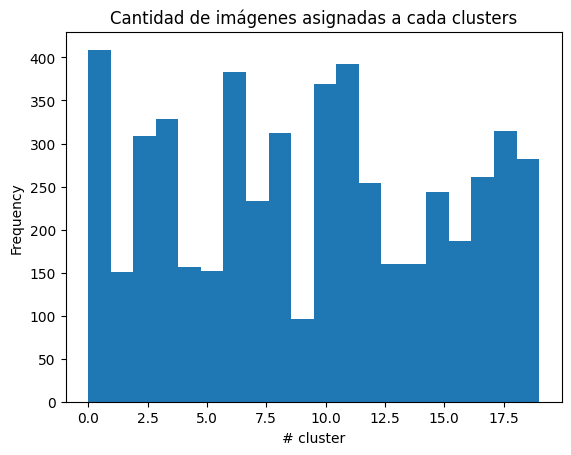

In [ ]:
import pandas as pd
plt.title("Cantidad de imágenes asignadas a cada clusters")
pd.Series(asignacion_clusters).plot.hist(bins=K)
plt.xlabel("# cluster")

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

Mostrando imágenes del cluster 10

/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000662.jpg


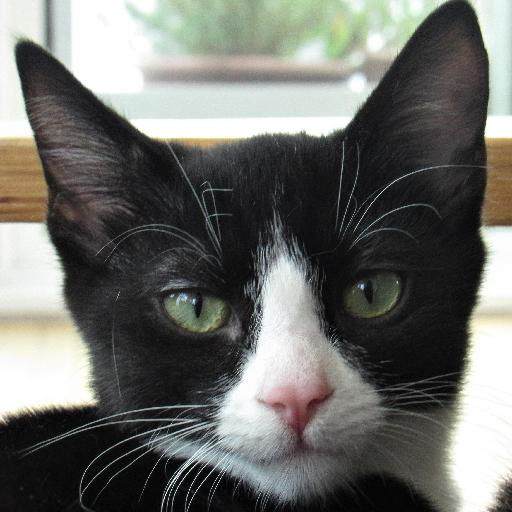

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001733.jpg


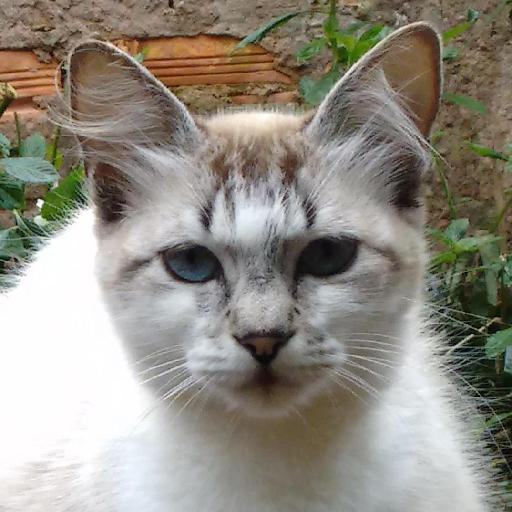

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_000155.jpg


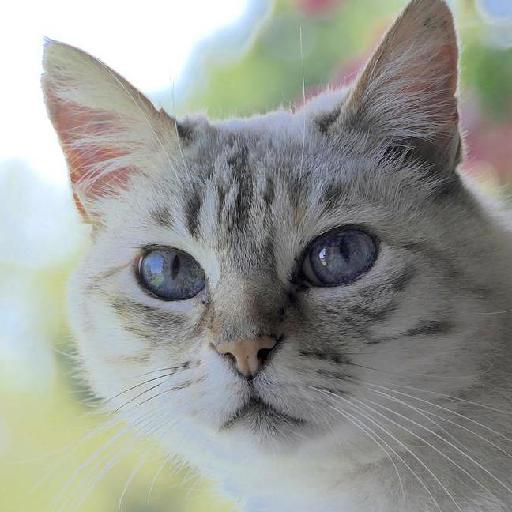

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002963.jpg


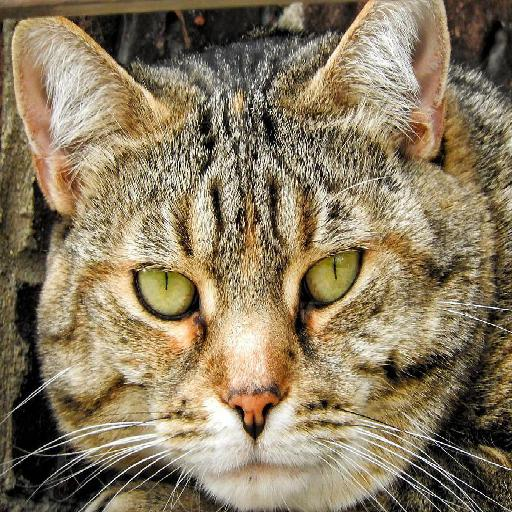

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004500.jpg


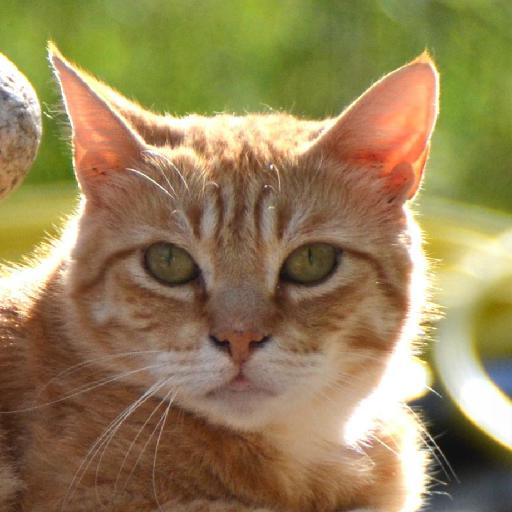

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002187.jpg


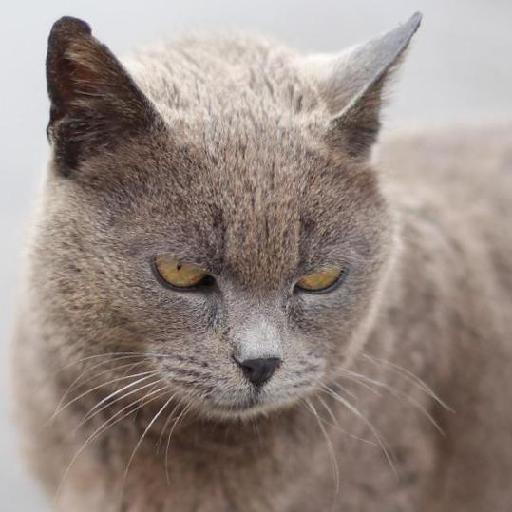

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_003696.jpg


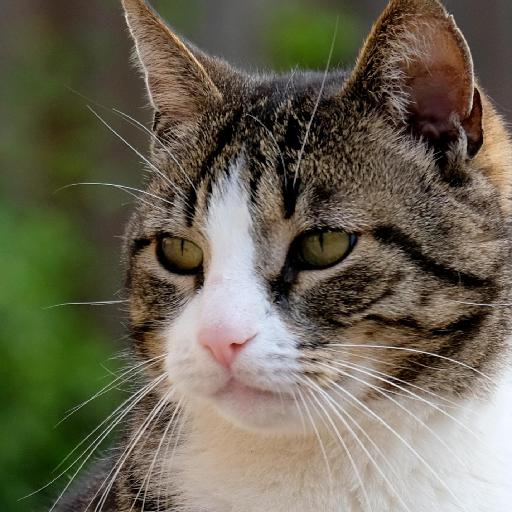

/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000141.jpg


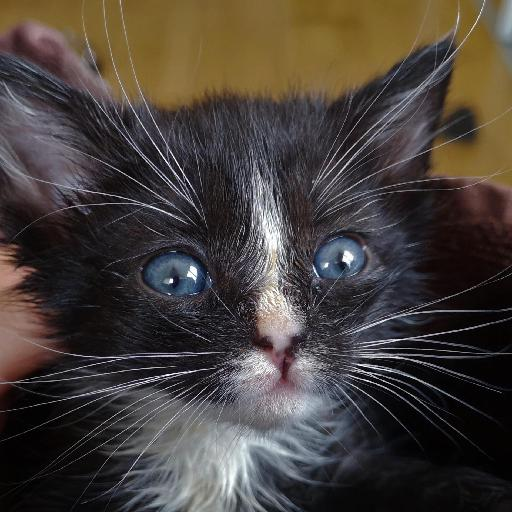

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001722.jpg


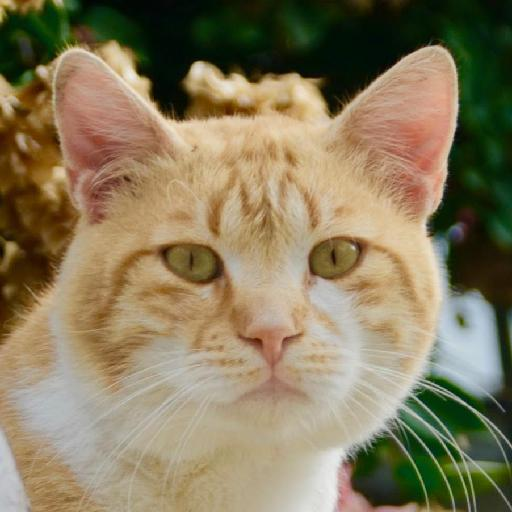

/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000587.jpg


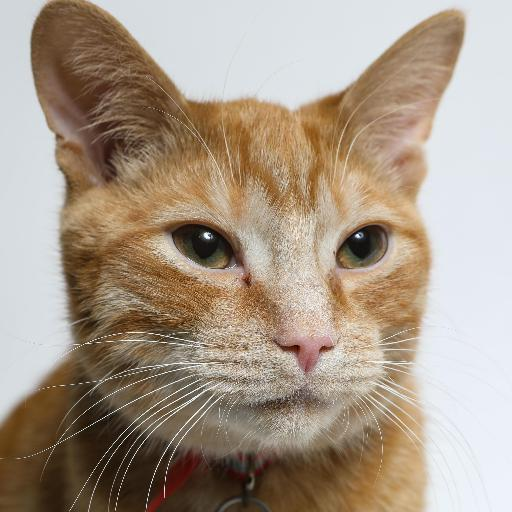

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001861.jpg


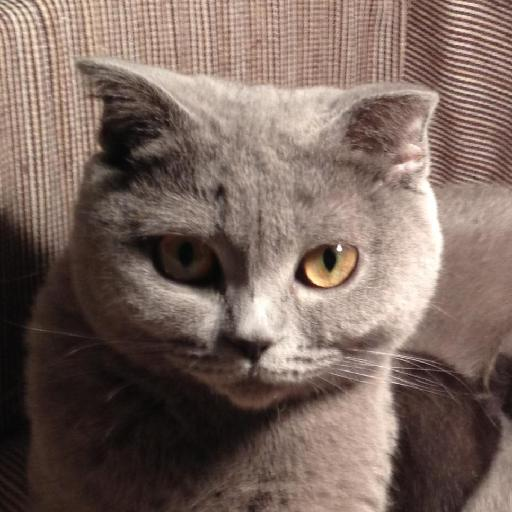

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001683.jpg


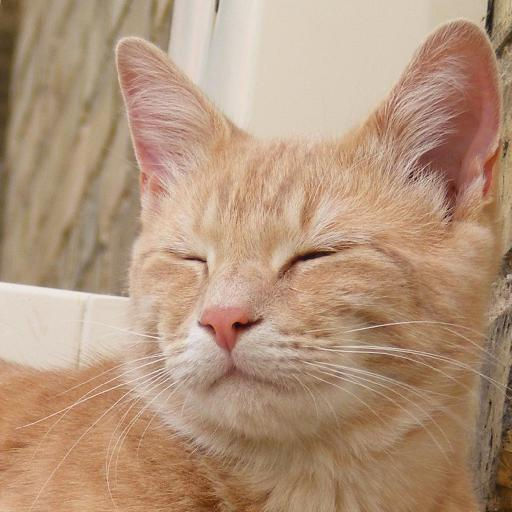

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001903.jpg


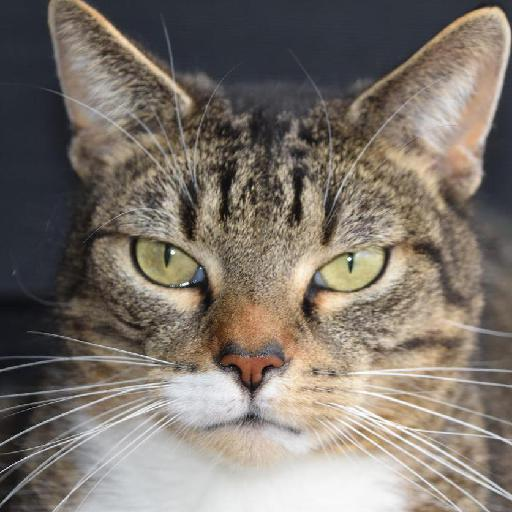

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004004.jpg


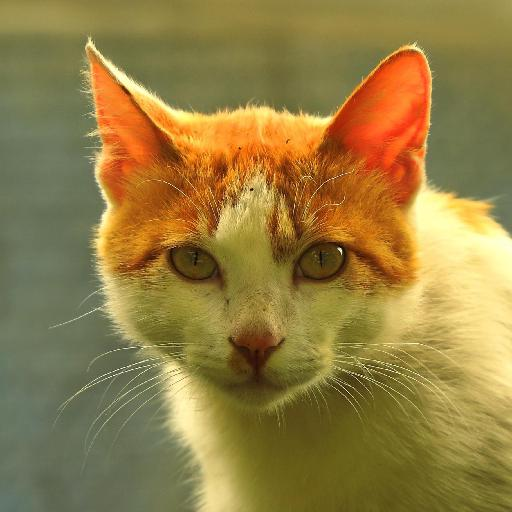

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001802.jpg


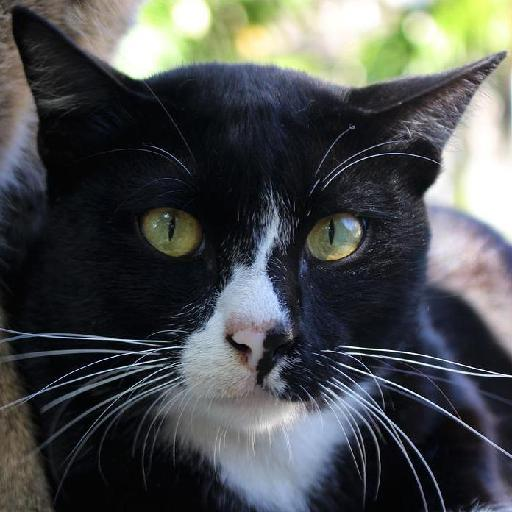

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004671.jpg


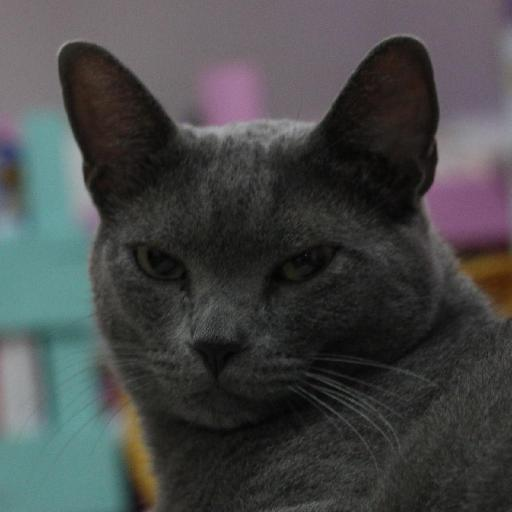

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004114.jpg


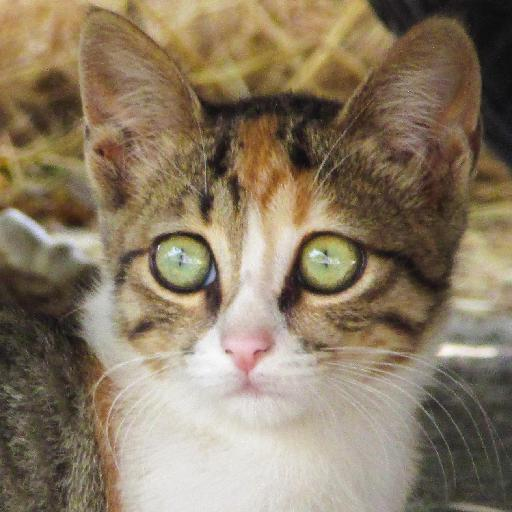

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001827.jpg


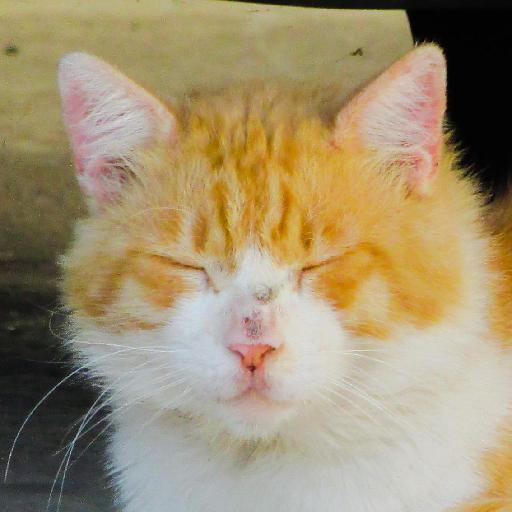

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001333.jpg


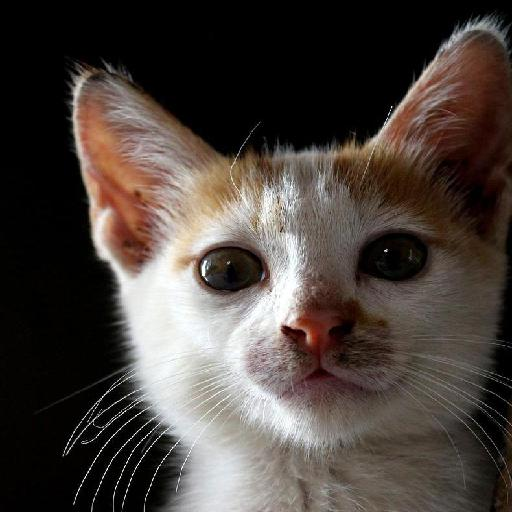

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_000230.jpg


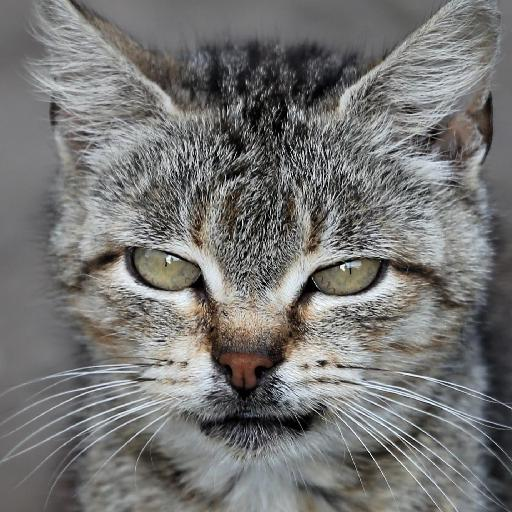

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004108.jpg


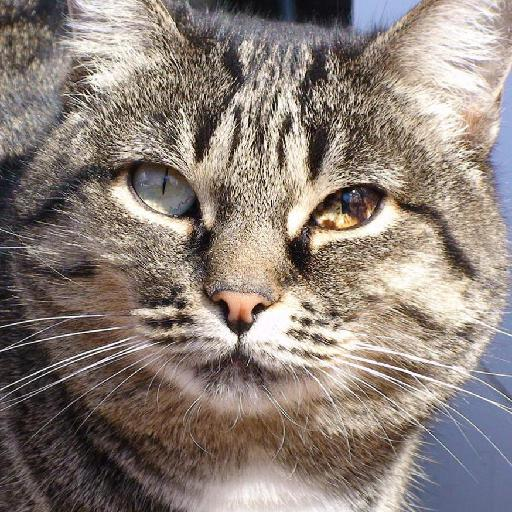

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_000067.jpg


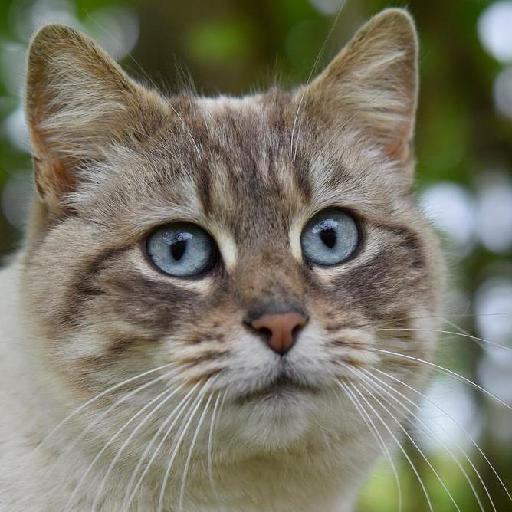

/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000457.jpg


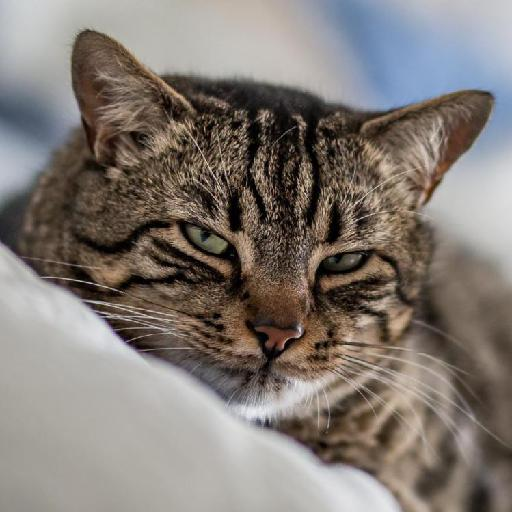

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001787.jpg


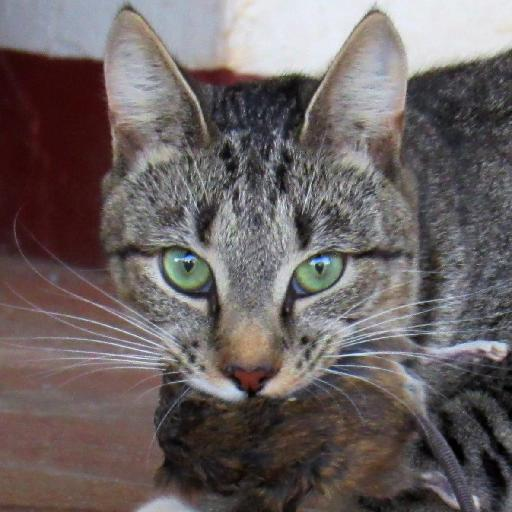

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004158.jpg


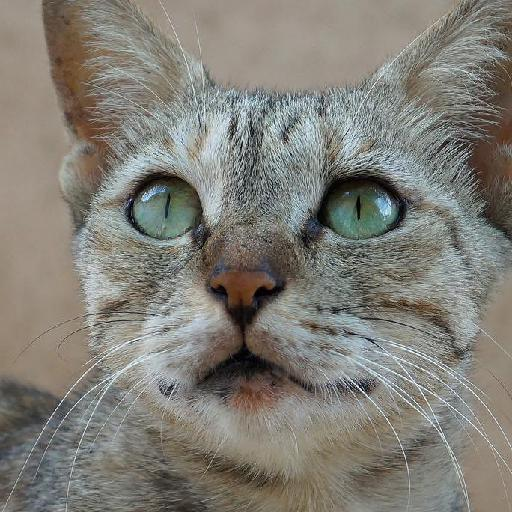

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001271.jpg


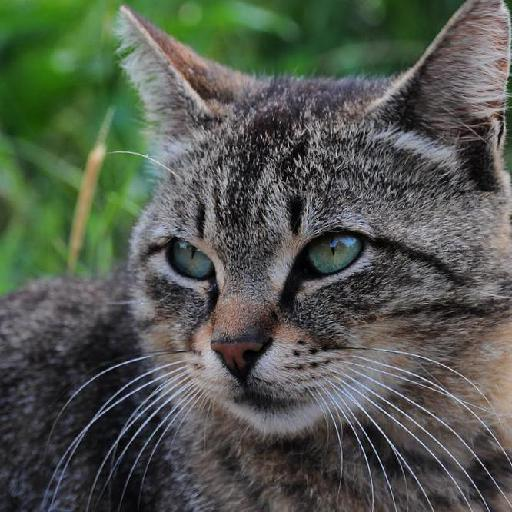

/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000104.jpg


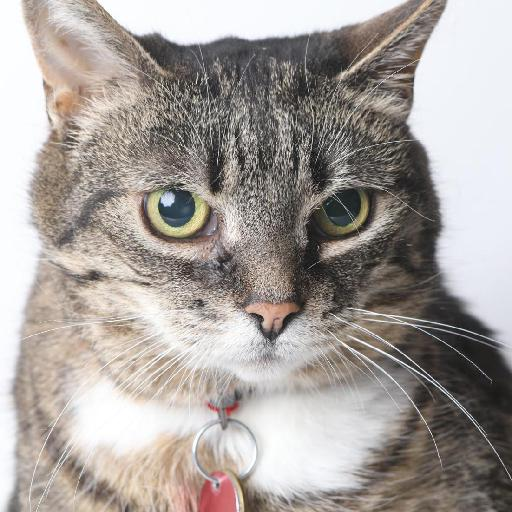

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004747.jpg


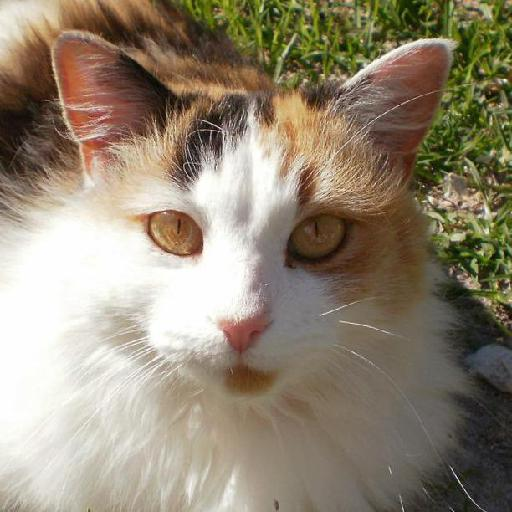

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_003258.jpg


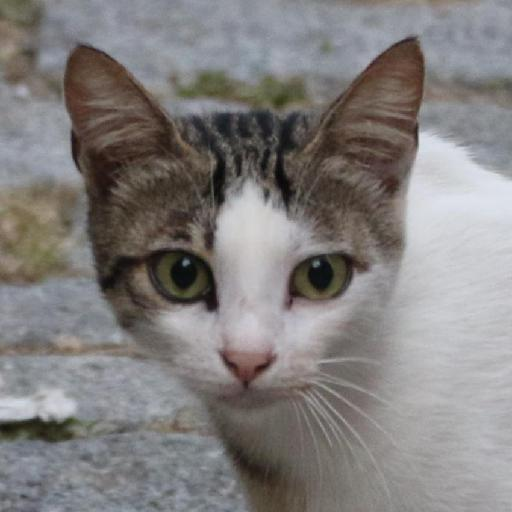

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002971.jpg


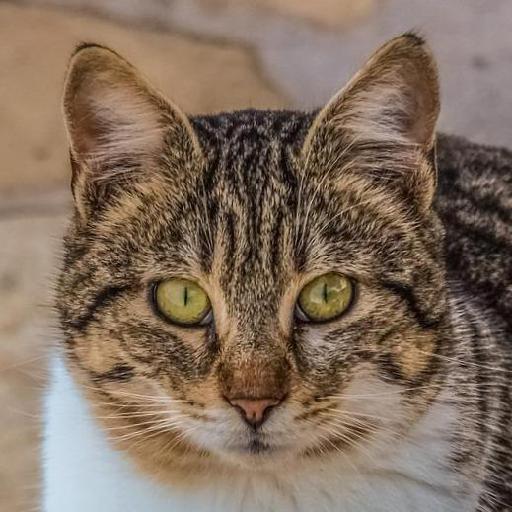

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_000620.jpg


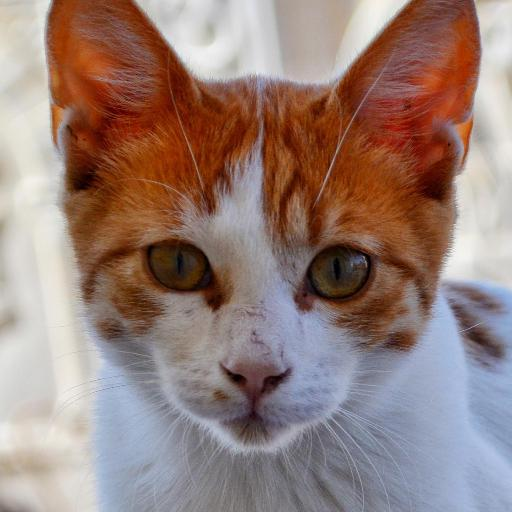

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002202.jpg


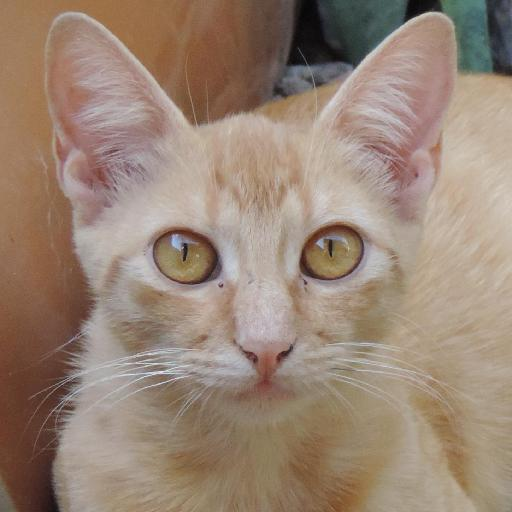

/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000403.jpg


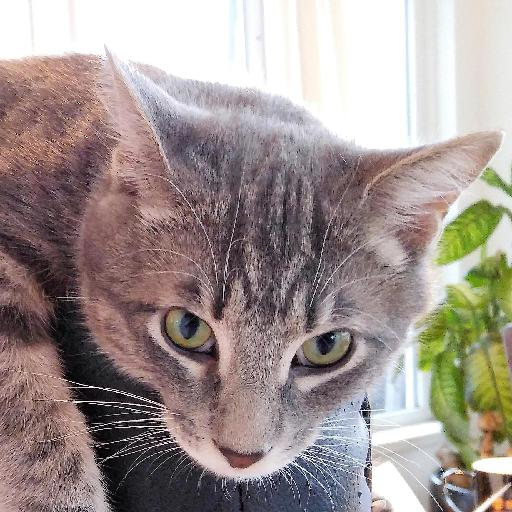

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002247.jpg


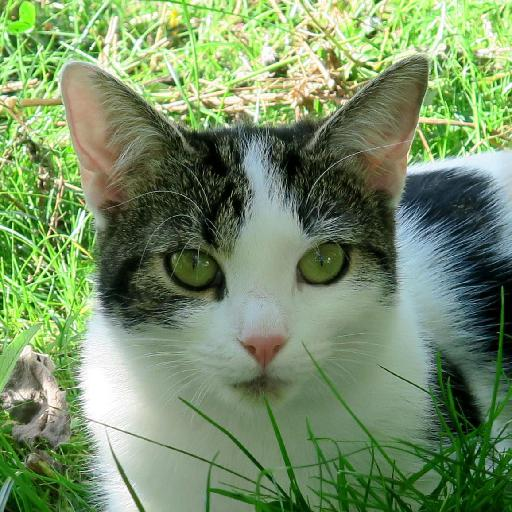

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004272.jpg


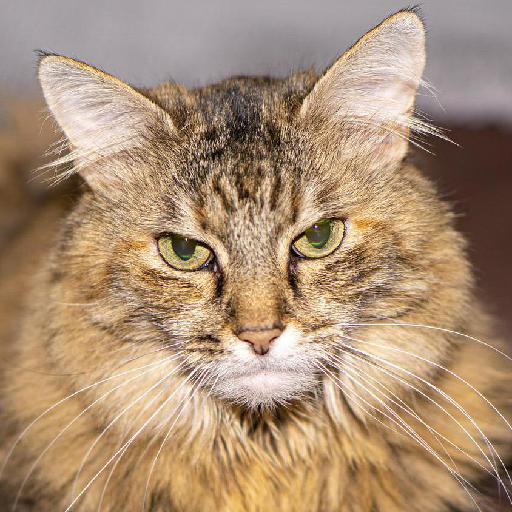

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_000664.jpg


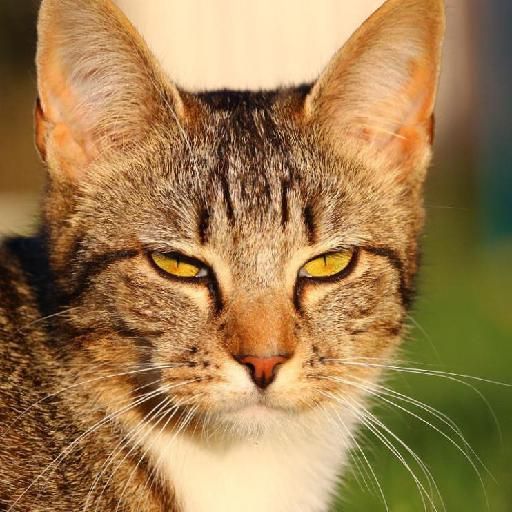

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002993.jpg


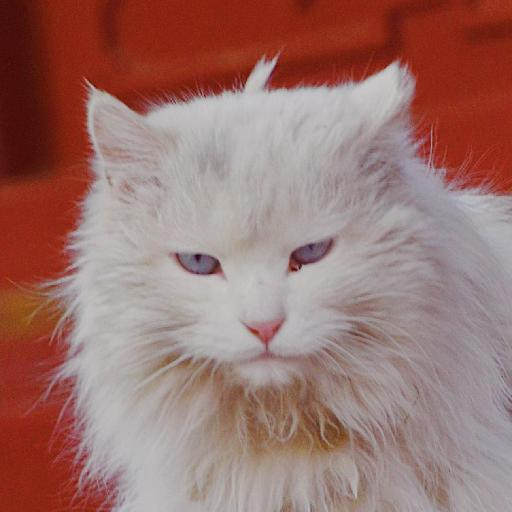

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002733.jpg


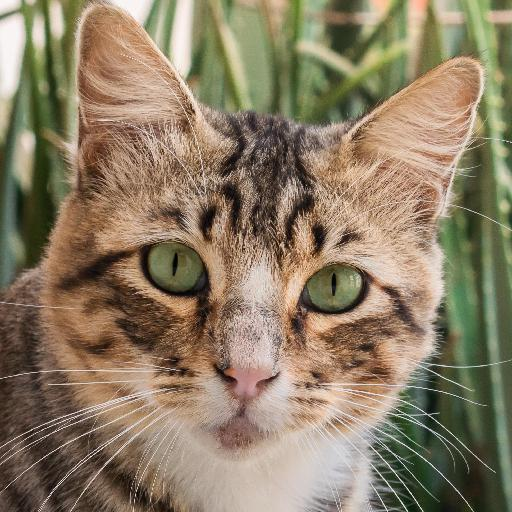

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001872.jpg


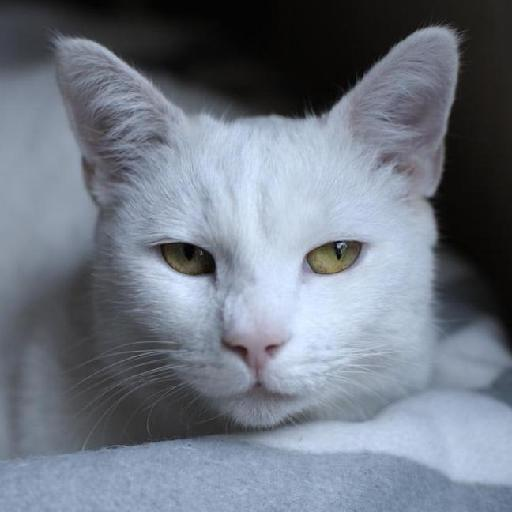

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002164.jpg


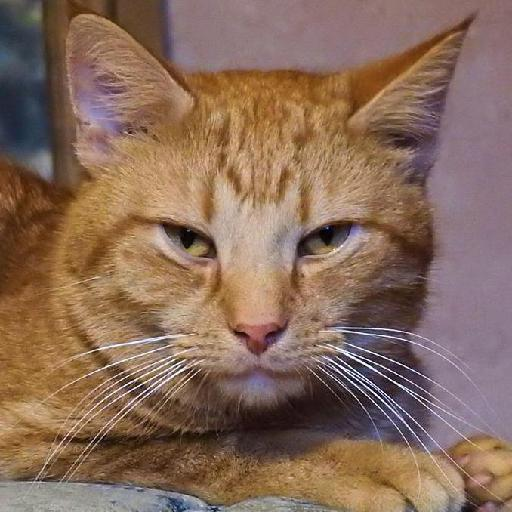

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_003763.jpg


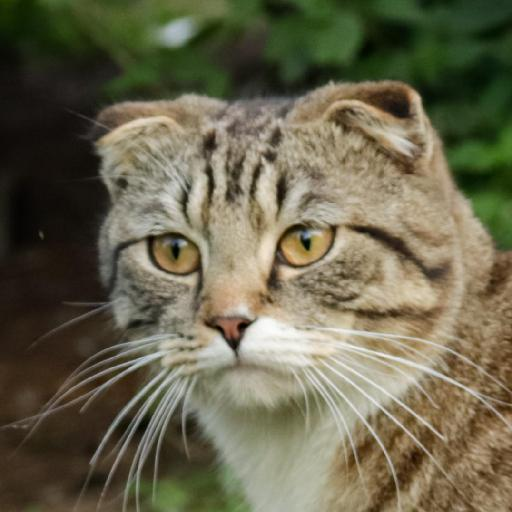

/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000810.jpg


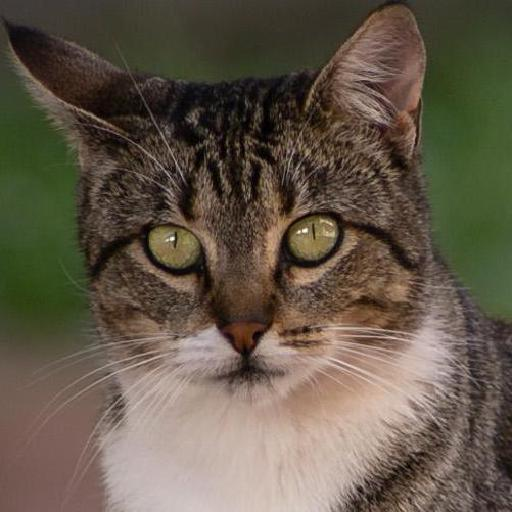

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004026.jpg


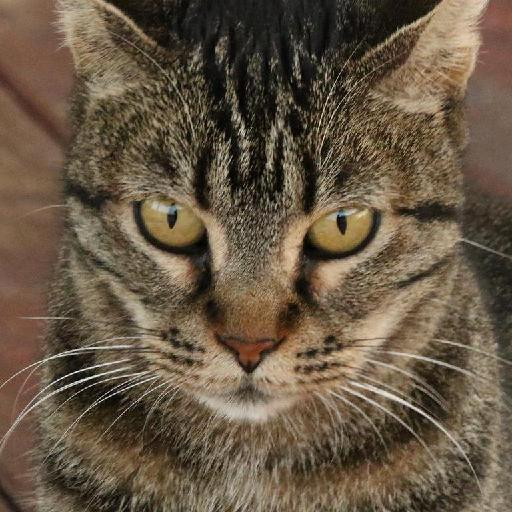

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_003369.jpg


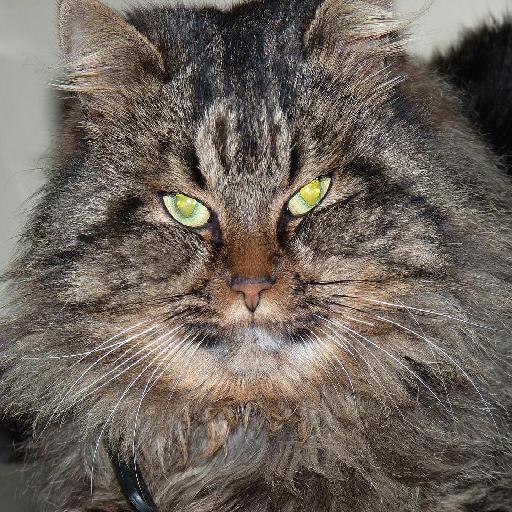

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004201.jpg


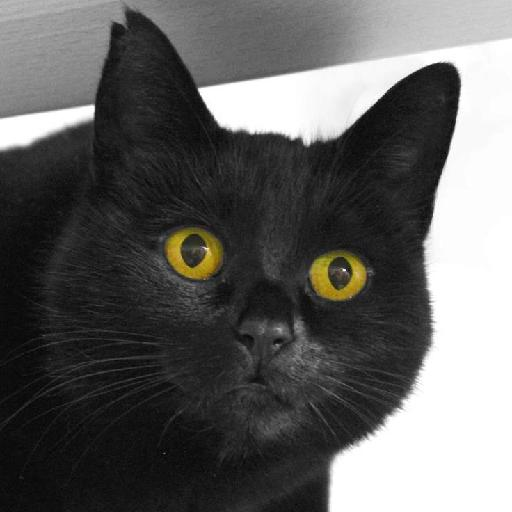

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004563.jpg


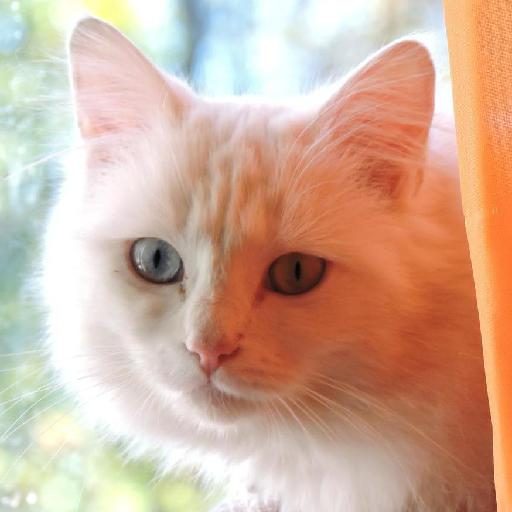

/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000453.jpg


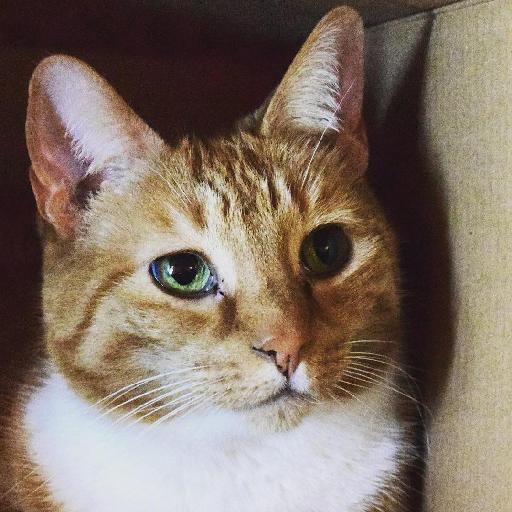

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_002497.jpg


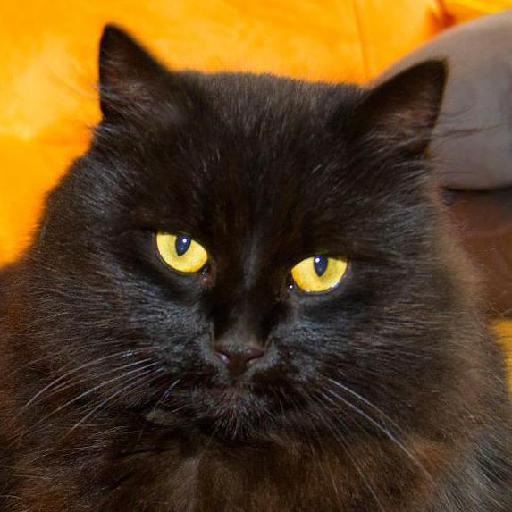

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_001866.jpg


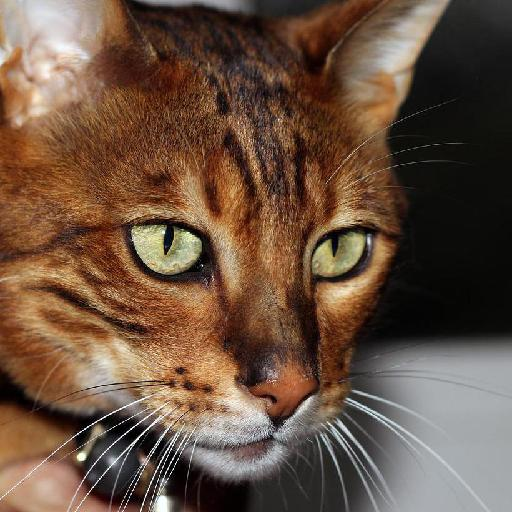

/kaggle/input/animal-faces/afhq/train/cat/pixabay_cat_004009.jpg


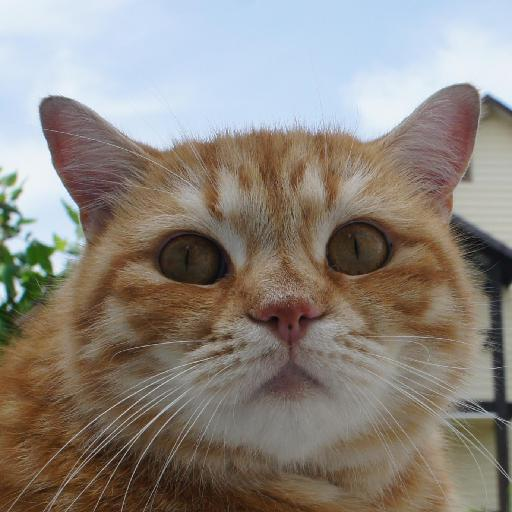

In [ ]:
from IPython.display import Image
cluster_id = 10 #número del cluster a visualizar
max_images = 50 #máxima cantidad de imágenes a visualizar

print("Mostrando imágenes del cluster {}\n".format(cluster_id))

imagenes_en_cluster = filenames[asignacion_clusters==cluster_id]

if len(imagenes_en_cluster)<= max_images:
  imagenes_a_mostrar = imagenes_en_cluster
else:
  imagenes_a_mostrar = np.random.choice(imagenes_en_cluster, max_images, replace=False)

i = 0
for filename in imagenes_a_mostrar:
  print(filename)
  display(Image(filename))
  i += 1
  if i > max_images:
    break

In [ ]:
import os
import glob

# Ruta de la carpeta
folder_path = '/kaggle/input/animal-faces/afhq/train/cat'

# Usando os.listdir()
num_files = len(os.listdir(folder_path))
print(f"Número de archivos en la carpeta usando os.listdir(): {num_files}")

# Usando glob
num_files_glob = len(glob.glob(os.path.join(folder_path, '*.jpg')))
print(f"Número de archivos en la carpeta usando glob: {num_files_glob}")


Número de archivos en la carpeta usando os.listdir(): 5153
Número de archivos en la carpeta usando glob: 5153


In [ ]:
wild_dir = '/kaggle/input/animal-faces/afhq/train/wild'
dog_dir = '/kaggle/input/animal-faces/afhq/train/dog'

shutil.rmtree(wild_dir, ignore_errors=True)
print(f"Directorio {wild_dir} borrado.")

shutil.rmtree(dog_dir, ignore_errors=True)
print(f"Directorio {dog_dir} borrado.")

Directorio /kaggle/input/animal-faces/afhq/train/wild borrado.
Directorio /kaggle/input/animal-faces/afhq/train/dog borrado.


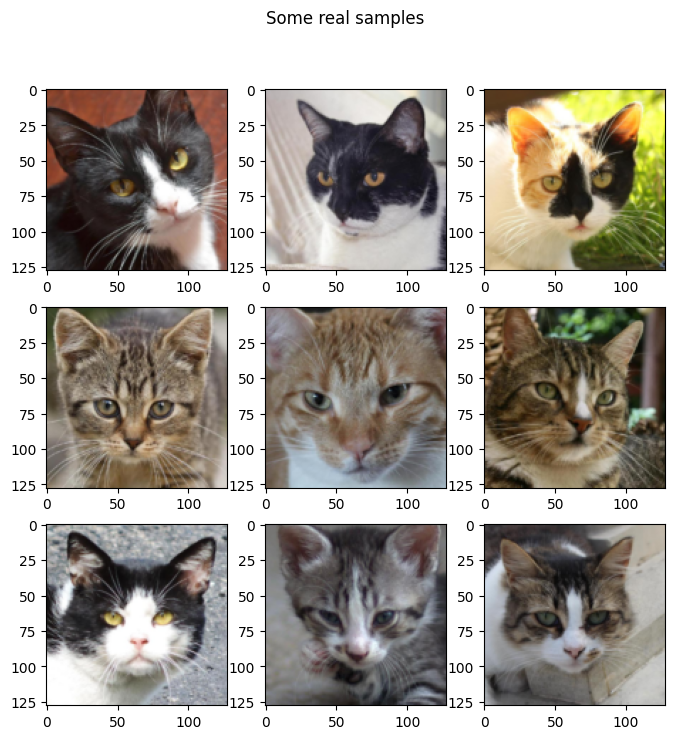

In [ ]:
check_loader()

#Definición de modelo StyleGAN

In [ ]:
# Noice apping network
# AdaIN
# Progressice growing
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [ ]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias

In [ ]:
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )

    def forward(self,x):
        return self.mapping(x)

In [ ]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

In [ ]:
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

In [ ]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [ ]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = torch.std(x, dim=0, unbiased=False).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

##Funciones para evaluación de rendimiento de los modelos StyleGAN

In [ ]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIm).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [ ]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
DATSET = '/kaggle/input/animal-faces/afhq/train'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [128,64,32,16,8,4,2,1]
CHANNELS_IMG = 3
Z_DIm = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [20,20,20,20,20,20]

In [ ]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    lambda_gp = LAMBDA_GP
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIm).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + lambda_gp * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha

In [ ]:
def save_model(model, optimizer, filename):
    state = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    torch.save(state, filename)

def load_model(model, optimizer, filename):
    state = torch.load(filename)
    model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer_state'])



In [ ]:
def save_model_parameters(model, filename):
    torch.save(model.state_dict(), filename)

El step inicial se calcula como el logaritmo base 2 del tamaño inicial de la imagen dividido por 4. Este valor indica a qué nivel de resolución comienza el entrenamiento. Por ejemplo, si START_TRAIN_IMG_SIZE es 4, entonces log2(4/4) es 0. Si START_TRAIN_IMG_SIZE es 8, entonces log2(8/4) es 1.

El bucle for recorre las listas de PROGRESSIVE_EPOCHS a partir del step inicial. PROGRESSIVE_EPOCHS es una lista que define el número de épocas a entrenar para cada nivel de resolución de imagen.

Si PROGRESSIVE_EPOCHS = [5, 5, 5, 5, 5, 5], entonces para cada nivel de resolución se entrenará durante 5 épocas.

Dentro de este bucle:

train_fn entrena el modelo por una época utilizando el tamaño de imagen actual.
alpha controla el nivel de mezcla de imágenes generadas entre diferentes resoluciones (usado en fade-in).
generate_examples guarda ejemplos de imágenes generadas después de completar todas las épocas para el nivel de resolución actual.
step se incrementa para avanzar al siguiente nivel de resolución.
Ejemplo de Ejecución
Supongamos que START_TRAIN_IMG_SIZE es 4 y PROGRESSIVE_EPOCHS es [5, 5, 5, 5, 5, 5].

Step Inicial

step = int(log2(4/4)) = 0
Empieza con imágenes de 4x4 píxeles.
Entrenamiento Progresivo

Para step = 0, num_epochs = 5:

Entrena con imágenes de 4x4 píxeles durante 5 épocas.
Genera ejemplos.
Incrementa step a 1.

Para step = 1, num_epochs = 5:

Entrena con imágenes de 8x8 píxeles durante 5 épocas.
Genera ejemplos.
Incrementa step a 2.

Este proceso se repite hasta que se completen todas las resoluciones definidas por PROGRESSIVE_EPOCHS.

Detalle del Incremento de step
Cada vez que el bucle exterior completa las épocas definidas por PROGRESSIVE_EPOCHS para una resolución específica, step se incrementa en 1, lo que duplica el tamaño de la imagen para el siguiente ciclo de entrenamiento.

#Preprocesamiento de datos

In [ ]:
import os
import random

def reduce_dataset_to_exact_size(folder_path, target_size):
    # Obtener la lista de todos los archivos de imagen en la carpeta
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Verificar el tamaño actual del conjunto de datos
    current_size = len(all_files)
    print(f"Tamaño actual del conjunto de datos: {current_size}")

    # Calcular cuántos archivos deben eliminarse
    num_files_to_remove = current_size - target_size
    if num_files_to_remove <= 0:
        print("El conjunto de datos ya es menor o igual al tamaño objetivo.")
        return

    print(f"Eliminando {num_files_to_remove} archivos al azar...")

    # Seleccionar archivos al azar para eliminar
    files_to_remove = random.sample(all_files, num_files_to_remove)

    # Eliminar los archivos seleccionados
    for file in files_to_remove:
        os.remove(os.path.join(folder_path, file))
        print(f"Eliminado: {file}")

    print(f"Nuevo tamaño del conjunto de datos: {len(os.listdir(folder_path))}")

# Ruta de la carpeta que deseas ajustar
folder_path = '/kaggle/input/animal-faces/afhq/train/cat'

# Tamaño objetivo del conjunto de datos
target_size = 5120

# Llamar a la función para ajustar el tamaño del conjunto de datos
reduce_dataset_to_exact_size(folder_path, target_size)


Tamaño actual del conjunto de datos: 5153
Eliminando 33 archivos al azar...
Eliminado: pixabay_cat_004723.jpg
Eliminado: pixabay_cat_000658.jpg
Eliminado: pixabay_cat_001373.jpg
Eliminado: pixabay_cat_001638.jpg
Eliminado: pixabay_cat_001234.jpg
Eliminado: pixabay_cat_003277.jpg
Eliminado: pixabay_cat_001386.jpg
Eliminado: pixabay_cat_001545.jpg
Eliminado: pixabay_cat_003602.jpg
Eliminado: pixabay_cat_001021.jpg
Eliminado: pixabay_cat_002363.jpg
Eliminado: pixabay_cat_004222.jpg
Eliminado: pixabay_cat_001238.jpg
Eliminado: pixabay_cat_001735.jpg
Eliminado: pixabay_cat_001101.jpg
Eliminado: pixabay_cat_001546.jpg
Eliminado: pixabay_cat_001754.jpg
Eliminado: flickr_cat_000412.jpg
Eliminado: pixabay_cat_000501.jpg
Eliminado: pixabay_cat_002777.jpg
Eliminado: pixabay_cat_003739.jpg
Eliminado: pixabay_cat_001781.jpg
Eliminado: pixabay_cat_004423.jpg
Eliminado: pixabay_cat_001044.jpg
Eliminado: pixabay_cat_001219.jpg
Eliminado: pixabay_cat_000280.jpg
Eliminado: pixabay_cat_001146.jpg
Elimina

#Entrenamiento del modelo

In [ ]:
import math  # Importar para verificar NaNs en variables tipo float

gc.collect()
torch.cuda.empty_cache()

gen = Generator(
    Z_DIm, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
print("Step inicial: " + str(step))
#step = 5
resume_training = False  # Cambia a True si deseas reanudar el entrenamiento
# Ruta del dataset

if resume_training:
    load_model(gen, opt_gen, 'generator__step' + str(step-1) + '.pth')
    load_model(critic, opt_critic, 'discriminator__step' + str(step-1) + '.pth')

for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5
    loader, dataset = get_loader_(4*2**step,DATSET)
    print('Current image size: ' + str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}]')
        alpha = train_fn(critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen)
            # Verificar si hay NaNs en la pérdida
        if math.isnan(alpha):
            print("Detected NaN in alpha. Saving model and stopping training.")
            save_model(gen, opt_gen, f'generator___step{step}_nan_detected.pth')
            save_model(critic, opt_critic, f'discriminator___step{step}_nan_detected.pth')
            break

        for param in critic.parameters():
            if torch.isnan(param).any():
                print("Detected NaN in critic parameters. Saving model and stopping training.")
                save_model(gen, opt_gen, f'generator___step{step}_nan_detected.pth')
                save_model(critic, opt_critic, f'discriminator___step{step}_nan_detected.pth')
                break

        for param in gen.parameters():
            if torch.isnan(param).any():
                print("Detected NaN in generator parameters. Saving model and stopping training.")
                save_model(gen, opt_gen, f'generator___step{step}_nan_detected.pth')
                save_model(critic, opt_critic, f'discriminator___step{step}_nan_detected.pth')
                break

    # Guardar modelos después de cada fase de entrenamiento
    save_model(gen, opt_gen, f'generator___step{step}.pth')
    save_model(critic, opt_critic, f'discriminator___step{step}.pth')

    generate_examples(gen, step)
    if step < len(PROGRESSIVE_EPOCHS) - 1:
        break
    step += 1
    print("Step: " + str(step))

# Supongamos que estás al final del entrenamiento
save_model_parameters(gen, 'generator_base.pth')
save_model_parameters(critic, 'discriminator_base.pth')


##Guardado de instantáneas del modelo

In [ ]:
from google.colab import files

gen_loaded = Generator(Z_DIm, W_DIM, IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
critic_loaded = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)

# Cargar los pesos guardados
gen_loaded.load_state_dict(torch.load('generator_base.pth'))
critic_loaded.load_state_dict(torch.load('discriminator_base.pth'))

# Opcional: cambiar los modelos a modo de evaluación si no se van a entrenar más
gen_loaded.eval()
critic_loaded.eval()

# Verificar que los modelos se han cargado correctamente
print("Generador y crítico cargados con éxito.")

In [ ]:
# Descargar modelos
files.download('generator_base.pth')
files.download('discriminator_base.pth')

In [ ]:
generate_examples(gen, step)

## Búsqueda de hiperparámetros

In [ ]:
!pip install torch torchvision numpy scipy pytorch-fid

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

##Funciones y modelos para evaluar Frechet Inception Distance

In [ ]:
import torch
from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn as nn

# Load and modify InceptionV3 model
weights = Inception_V3_Weights.DEFAULT
inception = inception_v3(weights=weights, transform_input=False)
inception.fc = torch.nn.Identity()  # Remove the final fully connected layer
inception.aux_logits = False  # Disable auxiliary logits

# Custom Sequential layer to adapt the final layer output to 512 dimensions
class ModifiedInception3(nn.Module):
    def __init__(self, inception):
        super(ModifiedInception3, self).__init__()
        self.inception = inception
        self.new_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
            nn.Flatten(),  # Flatten the tensor
            nn.Linear(2048, 512),  # Fully connected layer to reduce to 512 dimensions
            nn.ReLU(),  # Activation function
            nn.Dropout(p=0.5)  # Dropout for regularization
        )

    def forward(self, x):
        x = self.inception.Conv2d_1a_3x3(x)
        x = self.inception.Conv2d_2a_3x3(x)
        x = self.inception.Conv2d_2b_3x3(x)
        x = self.inception.maxpool1(x)
        x = self.inception.Conv2d_3b_1x1(x)
        x = self.inception.Conv2d_4a_3x3(x)
        x = self.inception.maxpool2(x)
        x = self.inception.Mixed_5b(x)
        x = self.inception.Mixed_5c(x)
        x = self.inception.Mixed_5d(x)
        x = self.inception.Mixed_6a(x)
        x = self.inception.Mixed_6b(x)
        x = self.inception.Mixed_6c(x)
        x = self.inception.Mixed_6d(x)
        x = self.inception.Mixed_6e(x)
        x = self.inception.Mixed_7a(x)
        x = self.inception.Mixed_7b(x)
        x = self.inception.Mixed_7c(x)
        x = self.new_layers(x)
        return x

# Replace the final layer block with our new custom layer
modified_inception = ModifiedInception3(inception)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modified_inception = modified_inception.to(device)

# Print the model layers to verify the changes
print(modified_inception)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 85.7MB/s]


ModifiedInception3(
  (inception): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_

In [ ]:
def test_model_input(model):
    """
    Function to test the expected input dimensions for the model.
    """
    print("Model Input Dimensions Check")

    # Define the correct input format
    input_tensor = torch.randn(25, 3, 299, 299).to(device)  # Using batch size of 25 and moving to the same device as the model

    print(f"Testing input format: {input_tensor.shape}")

    hooks = []

    def hook_fn(module, input, output):
        print(f"{module.__class__.__name__}: Input: {input[0].shape} Output: {output.shape}")

    for layer in model.children():
        hooks.append(layer.register_forward_hook(hook_fn))

    try:
        with torch.no_grad():
            _ = model(input_tensor)
    except Exception as e:
        print(f"Error with input format {input_tensor.shape}: {e}")

    # Remove hooks
    for hook in hooks:
        hook.remove()

test_model_input(modified_inception)

Model Input Dimensions Check
Testing input format: torch.Size([25, 3, 299, 299])
Sequential: Input: torch.Size([25, 2048, 8, 8]) Output: torch.Size([25, 512])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image
from pytorch_fid.inception import InceptionV3
from torchvision.models import inception_v3, Inception_V3_Weights
from pytorch_fid.fid_score import calculate_activation_statistics
import shutil
from scipy import linalg

'''def normalize_image(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

def normalize_image(tensor):
    tensor = tensor / 255.0
    return tensor
'''

# Set model to evaluation mode
modified_inception.eval()
modified_inception.to(DEVICE)


def normalize_image(tensor):
    return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(tensor)


class ImageFolderDataset(Dataset):
    def __init__(self, folder, transform=None, normalize=False):
        self.paths = [os.path.join(folder, p) for p in os.listdir(folder) if p.endswith('.jpg') or p.endswith('.png')]
        self.transform = transform
        self.normalize = normalize

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = Image.open(self.paths[index]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.normalize:
            img = normalize_image(img)
        return img

def get_activations(path, model, batch_size=64, dims=512, device='cpu', num_workers=1, normalize=False):
    model.eval()

    # List all files in the directory
    files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    transform = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor()])
    dataset = ImageFolderDataset(path, transform=transform, normalize=normalize)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in dataloader:
        batch = batch.to(device)
        #print(f'BATCH DIM: {batch.ndimension()} - BATCH SHAPE: {batch.shape}')

        if batch.ndimension() == 3:
            batch = batch.unsqueeze(0)  # Add batch dimension if missing

        try:
            with torch.no_grad():
                pred = model(batch)

            # If model output is not scalar, apply global spatial average pooling.
            if pred.ndimension() == 4 and (pred.size(2) != 1 or pred.size(3) != 1):
                pred = torch.nn.functional.adaptive_avg_pool2d(pred, output_size=(1, 1))

            pred = pred.squeeze(3).squeeze(2).cpu().numpy() if pred.ndimension() == 4 else pred.cpu().numpy()

            pred_arr[start_idx:start_idx + pred.shape[0]] = pred
            start_idx = start_idx + pred.shape[0]

        except Exception as e:
            print(f"Error processing batch: {e}")
            continue

    return pred_arr


def compute_statistics_of_path(path, model, batch_size, dims, device, normalize=False):
    """Calculates the mean and covariance of activations for images in a given path."""
    act = get_activations(path, model, batch_size, dims, device, normalize=normalize)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma



In [ ]:

def calculate_fid_given_paths(paths, batch_size, device, dims, model):
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size, dims, device,True)
    m2, s2 = compute_statistics_of_path(paths[1], model, batch_size, dims, device,True)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Regularización de las matrices de covarianza
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        print('Adding regularization to covariance matrices')
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            print('Covariance matrix had an imaginary component, regularizing it')
            covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from pytorch_fid import fid_score
import shutil
import gc
import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from PIL import Image
from scipy import linalg
from pytorch_fid.inception import InceptionV3

def resize_and_save_images(input_dir, output_dir, size):
    os.makedirs(output_dir, exist_ok=True)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(input_dir, filename)
            img = Image.open(img_path).convert("RGB")
            img = transform(img)
            save_image(img, os.path.join(output_dir, filename))

def generate_examples_and_calculate_fid(gen, steps, model_index, n=500, real_images_dir='/kaggle/input/animal-faces/afhq/val/cat'):
    gen.eval()
    generated_images_dir = f'saved_examples/model_{model_index}/step{steps}'
    os.makedirs(generated_images_dir, exist_ok=True)

    # Generar imágenes del modelo
    with torch.no_grad():
        for i in range(n):
            noise = torch.randn(1, Z_DIm).to(DEVICE)
            img = gen(noise, 1.0, steps)
            save_image(img * 0.5 + 0.5, os.path.join(generated_images_dir, f'img_{i}.png'))

    # Crear directorio temporal para imágenes reales redimensionadas
    resized_real_images_dir = f'resized_real_images/step{steps}'
    resize_and_save_images(real_images_dir, resized_real_images_dir, 4 * 2 ** steps)

    # Calcular el FID
    fid = calculate_fid_given_paths([resized_real_images_dir, generated_images_dir], batch_size=25, device=DEVICE, dims=512, model=modified_inception)

    # Limpiar directorios temporales
    shutil.rmtree(resized_real_images_dir)

    gen.train()
    return fid

#Grid search

In [ ]:
import math
import gc
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader
from pytorch_fid import fid_score
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image

def train_with_params(model_index, params):
    gc.collect()
    torch.cuda.empty_cache()

    gen = Generator(Z_DIm, W_DIM, IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
    critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
    opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                          {'params': gen.map.parameters(), 'lr': params['lr_gen']}],
                         lr=params['lr_gen'], betas=(params['beta1_gen'], params['beta2_gen']))
    opt_critic = optim.Adam(critic.parameters(), lr=params['lr_critic'],
                            betas=(params['beta1_critic'], params['beta2_critic']))

    gen.train()
    critic.train()
    step = int(log2(START_TRAIN_IMG_SIZE / 4))
    print("Step inicial: " + str(step))

    fids = []

    for num_epochs in params['progressive_epochs']:
        alpha = 1e-5
        loader, dataset = get_loader_(4*2**step, DATSET)
        print('Current image size: ' + str(4*2**step))

        for epoch in range(num_epochs):
            print(f'Epoch [{epoch + 1}/ {num_epochs}]')
            alpha = train_fn(critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen, params['lambda_gp'])

        # Guardar modelos después de cada fase de entrenamiento
        save_model(gen, opt_gen, f'generator{model_index}_step{step}.pth')
        save_model(critic, opt_critic, f'discriminator{model_index}_step{step}.pth')

        fid = generate_examples_and_calculate_fid(gen, step, model_index)
        fids.append((step, fid))
        step += 1
        print("Step: " + str(step))

    return fids


In [ ]:
from sklearn.model_selection import ParameterGrid

# Definir los rangos para la búsqueda en cuadrícula
param_grid = {
    'lr_gen': [1e-3, 1e-2],
    'lr_critic': [1e-3, 1e-2],
    'beta1_gen': [0.0, 0.5],
    'beta2_gen': [0.9, 0.99],
    'beta1_critic': [0.0, 0.5],
    'beta2_critic': [0.9, 0.99],
    'lambda_gp': [10],
    'batch_size': [[256, 256, 256, 128, 64]],
    'progressive_epochs': [[3, 3, 3, 3, 3, 3]]
}

# Generar todas las combinaciones de parámetros
grid = list(ParameterGrid(param_grid))


Entrenando con parámetros: {'batch_size': [256, 256, 256, 128, 64], 'beta1_critic': 0.0, 'beta1_gen': 0.0, 'beta2_critic': 0.9, 'beta2_gen': 0.9, 'lambda_gp': 10, 'lr_critic': 0.001, 'lr_gen': 0.001, 'progressive_epochs': [3, 3, 3, 3, 3, 3]}
Step inicial: 0
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 4
Epoch [1/ 3]


  0%|          | 0/40 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C

Epoch [2/ 3]


100%|██████████| 40/40 [00:16<00:00,  2.40it/s, gp=0.646, loss_critic=-2.4]


Epoch [3/ 3]


100%|██████████| 40/40 [00:16<00:00,  2.38it/s, gp=0.176, loss_critic=-8.19]


Step: 1
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 8
Epoch [1/ 3]


100%|██████████| 80/80 [00:23<00:00,  3.37it/s, gp=0.0458, loss_critic=-1.84]


Epoch [2/ 3]


100%|██████████| 80/80 [00:26<00:00,  2.98it/s, gp=0.0186, loss_critic=-1.49]


Epoch [3/ 3]


100%|██████████| 80/80 [00:22<00:00,  3.56it/s, gp=0.00611, loss_critic=-0.943]


Step: 2
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 16
Epoch [1/ 3]


100%|██████████| 160/160 [00:57<00:00,  2.80it/s, gp=0.0343, loss_critic=-0.912]


Epoch [2/ 3]


100%|██████████| 160/160 [00:57<00:00,  2.80it/s, gp=0.00704, loss_critic=0.0398]


Epoch [3/ 3]


100%|██████████| 160/160 [00:57<00:00,  2.80it/s, gp=0.0143, loss_critic=0.475]


Step: 3
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 32
Epoch [1/ 3]


100%|██████████| 320/320 [03:25<00:00,  1.56it/s, gp=0.0284, loss_critic=-3.16]


Epoch [2/ 3]


100%|██████████| 320/320 [03:25<00:00,  1.56it/s, gp=0.0174, loss_critic=-3.29]


Epoch [3/ 3]


100%|██████████| 320/320 [03:25<00:00,  1.56it/s, gp=0.0127, loss_critic=-2.35]


Step: 4
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 64
Epoch [1/ 3]


100%|██████████| 640/640 [09:37<00:00,  1.11it/s, gp=0.11, loss_critic=-4.1]


Epoch [2/ 3]


100%|██████████| 640/640 [09:37<00:00,  1.11it/s, gp=0.0209, loss_critic=-1.55]


Epoch [3/ 3]


100%|██████████| 640/640 [09:37<00:00,  1.11it/s, gp=0.0241, loss_critic=-4.07]


Step: 5
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 128
Epoch [1/ 3]


100%|██████████| 1280/1280 [20:07<00:00,  1.06it/s, gp=0.286, loss_critic=-3.74]


Epoch [2/ 3]


100%|██████████| 1280/1280 [20:07<00:00,  1.06it/s, gp=0.0246, loss_critic=-2.1]


Epoch [3/ 3]


100%|██████████| 1280/1280 [20:05<00:00,  1.06it/s, gp=0.019, loss_critic=-3.03]


Step: 6
[(0, (3.039576437579799-3.797676847493725e-10j)), (1, (5.622686222764264-2.8736272779162263e-11j)), (2, 5.124346004874851), (3, 9.73198313281691), (4, 8.21395144954284), (5, (8.268477177123648-3.036305868913626e-10j))]
FID score with parameters {'batch_size': [256, 256, 256, 128, 64], 'beta1_critic': 0.0, 'beta1_gen': 0.0, 'beta2_critic': 0.9, 'beta2_gen': 0.9, 'lambda_gp': 10, 'lr_critic': 0.001, 'lr_gen': 0.001, 'progressive_epochs': [3, 3, 3, 3, 3, 3]}: (8.268477177123648-3.036305868913626e-10j)


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


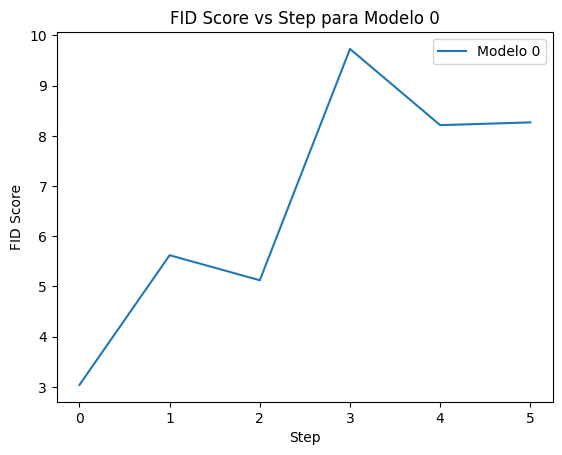

Entrenando con parámetros: {'batch_size': [256, 256, 256, 128, 64], 'beta1_critic': 0.0, 'beta1_gen': 0.0, 'beta2_critic': 0.9, 'beta2_gen': 0.9, 'lambda_gp': 10, 'lr_critic': 0.001, 'lr_gen': 0.01, 'progressive_epochs': [3, 3, 3, 3, 3, 3]}
Step inicial: 0
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 4
Epoch [1/ 3]


100%|██████████| 40/40 [00:16<00:00,  2.43it/s, gp=0.855, loss_critic=-547]


Epoch [2/ 3]


100%|██████████| 40/40 [00:16<00:00,  2.41it/s, gp=2.15, loss_critic=1.64]


Epoch [3/ 3]


100%|██████████| 40/40 [00:18<00:00,  2.20it/s, gp=1.64, loss_critic=7.91]


Step: 1
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 8
Epoch [1/ 3]


100%|██████████| 80/80 [00:23<00:00,  3.42it/s, gp=0.00355, loss_critic=2.82]


Epoch [2/ 3]


100%|██████████| 80/80 [00:23<00:00,  3.45it/s, gp=0.0147, loss_critic=0.855]


Epoch [3/ 3]


100%|██████████| 80/80 [00:23<00:00,  3.41it/s, gp=0.00608, loss_critic=-0.369]


Step: 2
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 16
Epoch [1/ 3]


100%|██████████| 160/160 [00:57<00:00,  2.79it/s, gp=0.0147, loss_critic=-0.378]


Epoch [2/ 3]


100%|██████████| 160/160 [00:57<00:00,  2.79it/s, gp=0.00639, loss_critic=0.507]


Epoch [3/ 3]


100%|██████████| 160/160 [00:57<00:00,  2.80it/s, gp=0.0187, loss_critic=2.83]


Step: 3
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 32
Epoch [1/ 3]


100%|██████████| 320/320 [03:25<00:00,  1.56it/s, gp=0.0173, loss_critic=2.22]


Epoch [2/ 3]


100%|██████████| 320/320 [03:25<00:00,  1.56it/s, gp=0.178, loss_critic=-8.66]


Epoch [3/ 3]


100%|██████████| 320/320 [03:24<00:00,  1.56it/s, gp=0.0622, loss_critic=-7.67]


Step: 4
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 64
Epoch [1/ 3]


100%|██████████| 640/640 [09:37<00:00,  1.11it/s, gp=0.363, loss_critic=-13.8]


Epoch [2/ 3]


100%|██████████| 640/640 [09:37<00:00,  1.11it/s, gp=0.149, loss_critic=-2.24]


Epoch [3/ 3]


100%|██████████| 640/640 [09:37<00:00,  1.11it/s, gp=0.0435, loss_critic=-8.49]


Step: 5
Subcarpetas encontradas: ['/kaggle/input/animal-faces/afhq/train/cat']
Current image size: 128
Epoch [1/ 3]


100%|██████████| 1280/1280 [20:05<00:00,  1.06it/s, gp=0.0667, loss_critic=7.76]


Epoch [2/ 3]


100%|██████████| 1280/1280 [20:05<00:00,  1.06it/s, gp=0.0801, loss_critic=1.05]


Epoch [3/ 3]


 31%|███       | 393/1280 [06:10<13:54,  1.06it/s, gp=0.0337, loss_critic=-7.67]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

best_fid = np.inf
best_params = None
best_i = -1

all_fids = {}

for i, params in enumerate(grid):
    print(f"Entrenando con parámetros: {params}")
    fids = train_with_params(i, params)
    print(fids)
    all_fids[i] = fids
    final_fid = fids[-1][1]
    print(f'FID score with parameters {params}: {final_fid}')

    if final_fid < best_fid:
        best_fid = final_fid
        best_params = params
        best_i = i

    # Plot FID scores for the current model without a logarithmic scale
    steps, fid_scores = zip(*fids)
    plt.figure()
    plt.plot(steps, fid_scores, label=f'Modelo {i}')
    plt.xlabel('Step')
    plt.ylabel('FID Score')
    plt.title(f'FID Score vs Step para Modelo {i}')
    plt.legend()
    plt.savefig(f'fid_plot_model_{i}.png')
    plt.show()

print(f'Mejor modelo {best_i} con FID: {best_fid} y parámetros: {best_params}')

# Plot FID scores for all models on a single plot without a logarithmic scale
plt.figure()
for model_index, fids in all_fids.items():
    steps, fid_scores = zip(*fids)
    plt.plot(steps, fid_scores, label=f'Modelo {model_index}')
plt.xlabel('Step')
plt.ylabel('FID Score')
plt.title('FID Score vs Step para cada Modelo')
plt.legend()
plt.savefig('fid_plot_all_models.png')
plt.show()


In [ ]:
# Plotear los FID scores de todos los modelos juntos
plt.figure()
for model_index, fids in all_fids.items():
    steps, fid_scores = zip(*fids)
    plt.plot(steps, fid_scores, label=f'Modelo {model_index}')

plt.xlabel('Step')
plt.ylabel('FID Score')
plt.title('FID Score vs Step para cada Modelo')
plt.legend()
plt.savefig('fid_plot_all_models.png')
plt.show()

In [ ]:
##Carga del generador
from google.colab import files
#Carga de generador
gen_loaded = Generator(Z_DIm, W_DIM, IN_CHANNELS, CHANNELS_IMG).to(DEVICE)

# Cargar los pesos guardados
gen_loaded.load_state_dict(torch.load('generator_final.pth'))

# Verificar que los modelos se han cargado correctamente
print("Generador cargado con éxito.")

Generador cargado con éxito.


Step: 0 - FID: 3.296785419824324
Step: 1 - FID: (9.935238453331419-4.5963122891892405e-10j)
Step: 2 - FID: 10.476008206065512
Step: 3 - FID: 10.468692448870392
Step: 4 - FID: 9.938555883886286
Step: 5 - FID: (8.805828471874998-1.118474294497516e-10j)


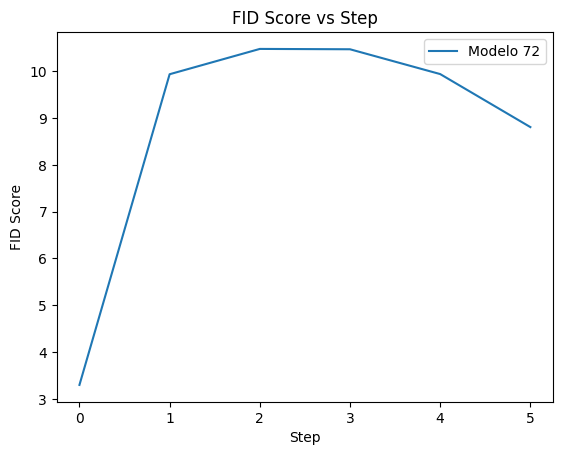

In [ ]:
#Visualización de resultados del modelo 72
fids=[]

for i in range(6):
    fid = generate_examples_and_calculate_fid(gen, i, 72)
    print(f'Step: {i} - FID: {fid}')
    fids.append((i, fid))

# Graficar Step vs FID Score
steps, fid_scores = zip(*fids)
plt.figure()
plt.plot(steps, fid_scores, label='Modelo 72')
plt.xlabel('Step')
plt.ylabel('FID Score')
plt.title('FID Score vs Step')
plt.legend()
plt.savefig('fid_plot_model_72.png')
plt.show()

In [ ]:
generate_examples(gen_loaded, 5, 500):